In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import numpy as np
import matplotlib.patches as mpatches

In [2]:
cards = pd.read_csv('TCG_data_all_cards.csv', encoding='latin-1')

In [3]:
#potrzebujemy tej funkcji ze względu na naturę danych — dane są jakby fałszywym słownikiem, więc zmieniamy string na prawdziwy słownik
def parse_legalities(val):
    try:
        if pd.isna(val): return {}
        return ast.literal_eval(val) if isinstance(val, str) else val
    except: return {}

df_base = cards.copy()
df_base['legalities_dict'] = df_base['legalities'].apply(parse_legalities)

In [4]:
gen_order = ['First', 'Second', 'Third', 'Fourth', 'Fifth', 'Sixth', 'Seventh', 'Eighth', 'Ninth', 'Other']
#kolory dla Generations
gen_colors = {
    'First': '#a65628', 'Second': '#e41a1c', 'Third': '#ff7f00',
    'Fourth': '#ffff33', 'Fifth': '#4daf4a', 'Sixth': '#377eb8',
    'Seventh': '#984ea3', 'Eighth': '#f781bf', 'Ninth': '#250491', 'Other': '#999999'
}
#kolory dla Supertype
pie_colors_map = {'Pokémon': '#6f62ac', 'Trainer': '#419584'}

In [5]:
#tworzymy dwa zbiory danych dla formatów Unlimited i Expanded cart zbanowanych
def is_unlimited_banned(d):
    return isinstance(d, dict) and d.get('unlimited') == 'Banned'
df_unlimited = df_base[df_base['legalities_dict'].apply(is_unlimited_banned)].copy()
df_unlimited['Format'] = 'Unlimited'
def is_expanded_banned(d):
    return isinstance(d, dict) and d.get('expanded') == 'Banned'
df_expanded = df_base[df_base['legalities_dict'].apply(is_expanded_banned)].copy()
df_expanded['Format'] = 'Expanded'

#łączymy zbanowane karty w obu formatach
df_combined = pd.concat([df_expanded, df_unlimited])
#tu warto dodać, że nie ma karty która jest zbanowana w obu formatach gry naraz, nie ma wię problemu z powdójnym zliczeniem karty

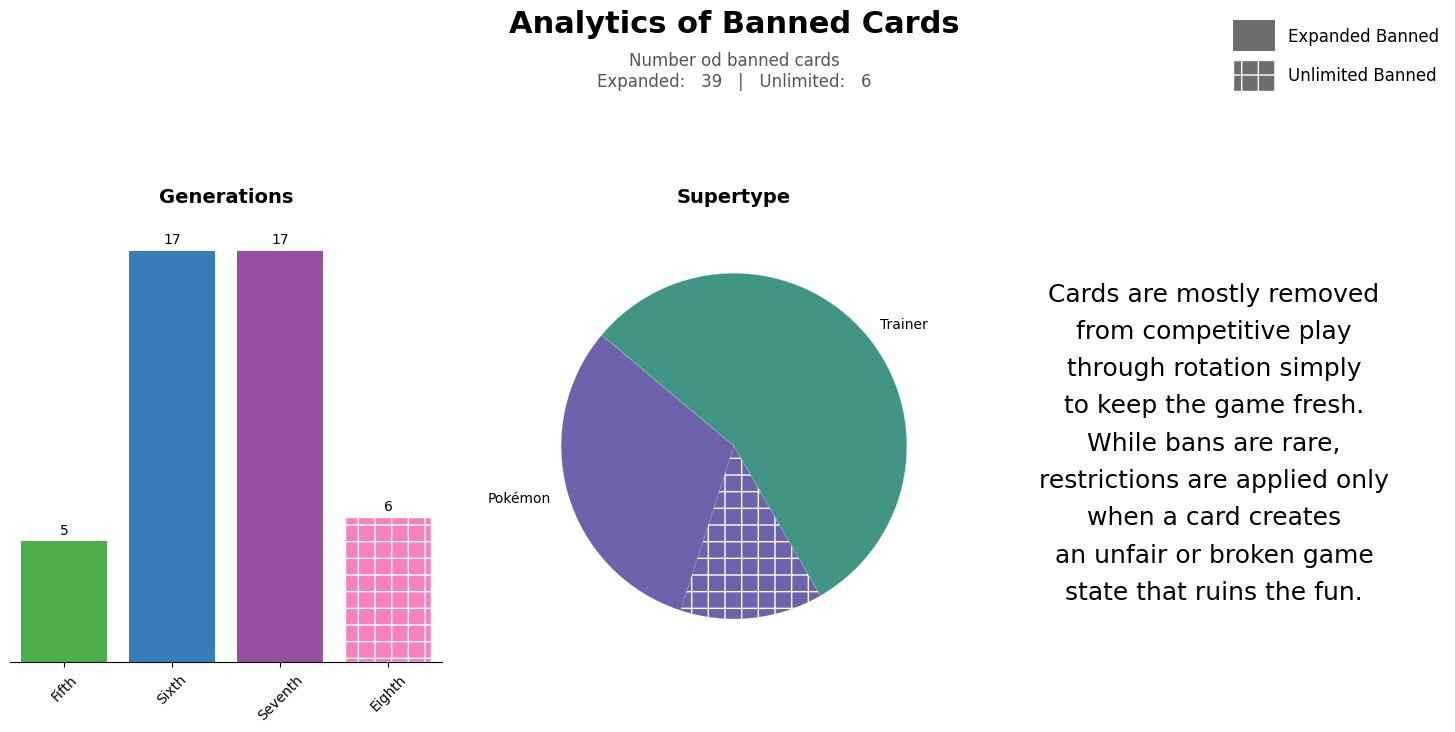

In [22]:
existing_gens = df_combined['generation'].unique()
plot_gen_order = [g for g in gen_order if g in existing_gens]

#wykres
fig = plt.figure(figsize=(16, 9), dpi=100)

#obliczanie rozmieszczenia wykresów — ręcznie ponieważ mamy po boku tekst
w_rel = 0.27
h_rel = w_rel * (16 / 9)
bottom_margin = 0.22
gap = (1.0 - (3 * w_rel)) / 4
x1 = gap
x2 = gap + w_rel + gap
x3 = gap + w_rel + gap + w_rel + gap + 0.03


#wykres 1 — generacje 
ax1 = fig.add_axes([x1, bottom_margin, w_rel, h_rel])

gen_counts = df_combined.groupby(['generation', 'Format']).size().reset_index(name='count')

sns.barplot(
    data=gen_counts, 
    x='generation', 
    y='count', 
    hue='Format', 
    hue_order=['Expanded', 'Unlimited'],
    order=plot_gen_order,
    palette=['#555555', '#555555'], #ten kolor zostanie nadpisany
    ax=ax1
)
#biblioteka Seaborn domyślnie koloruje tu słupki według formatu, a my chcemy kolorować po generacjach, dlatego nadpisujemy odpowiednie kolory
def color_bars(ax, color_map):
    xticks = ax.get_xticks()
    xticklabels = [label.get_text() for label in ax.get_xticklabels()]
    #tu też robimy to wyszystko ręcznie, ponieważ w klasyczny sposób robi się problem z kolorem i hatch

    #iterujemy po formatach — containers (0=Expanded, 1=Unlimited)
    for i, container in enumerate(ax.containers):
        is_unlimited = (i == 1)
        for bar in container:
            #obliczamy środek słupka
            bar_x = bar.get_x() + bar.get_width() / 2
            #znajdujemy indeks (najbliższego) ticka na osi X
            closest_idx = np.abs(xticks - bar_x).argmin()
            #pobieramy nazwę generacji z tego ticka
            if closest_idx < len(xticklabels):
                gen_name = xticklabels[closest_idx]
                #pobieranie i ustawianie koloru
                color = color_map.get(gen_name, '#000000')
                bar.set_facecolor(color)
                bar.set_alpha(1)
                #hatch tylko dla Unlimited
                if is_unlimited:
                    bar.set_hatch('+')
                    bar.set_edgecolor('white')

color_bars(ax1, gen_colors)

ax1.set_title('Generations', fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_yticks([])
ax1.tick_params(axis='x', labelrotation=45)
ax1.get_legend().remove()
sns.despine(ax=ax1, left=True)
for c in ax1.containers: 
    ax1.bar_label(c, fontsize=10, padding=3)


#wykres 2 Supertype
ax2 = fig.add_axes([x2, bottom_margin, w_rel, h_rel])
group_data = df_combined.groupby(['supertype', 'Format']).size()

pie_sizes = []
pie_colors = []
pie_labels = []
pie_hatches = []

all_supertypes = sorted(df_combined['supertype'].unique())

for st in all_supertypes:
    base_color = pie_colors_map.get(st, '#000000')
    
    # Expanded
    count_exp = group_data.get((st, 'Expanded'), 0)  #.get(klucz) jest zabezpieczeniem przed sytuacją gdzie typ nie występuje w formacie
    if count_exp > 0:
        pie_sizes.append(count_exp)
        pie_colors.append(base_color)
        pie_labels.append(st)
        pie_hatches.append('')

    # Unlimited
    count_unl = group_data.get((st, 'Unlimited'), 0)
    if count_unl > 0:
        pie_sizes.append(count_unl)
        pie_colors.append(base_color)
        pie_labels.append("")
        pie_hatches.append('+')

wedges, texts, autotexts = ax2.pie(
    pie_sizes, 
    labels=pie_labels, 
    autopct='', 
    colors=pie_colors, 
    startangle=140,
    wedgeprops={'edgecolor': 'white', 'linewidth': 0.1}
)

for i, wedge in enumerate(wedges):
    if pie_hatches[i]:
        wedge.set_hatch(pie_hatches[i])
        wedge.set_edgecolor('white')
        wedge.set_linewidth(0)


ax2.set_title('Supertype', fontsize=14, fontweight='bold', pad=20)


# legenda i text
#tworzymy własną legendę, ponieważ standardowa legenda biblioteki Seaborn pokazywałaby kolory generacji, a my chcemy pokazać rozróżnienie formatów
legend_handles = [
    mpatches.Patch(facecolor='#6D6D6D', label='Expanded Banned'),
    mpatches.Patch(facecolor='#6D6D6D', hatch='+', edgecolor='white', label='Unlimited Banned')]

fig.legend(
    handles=legend_handles, loc='upper right', bbox_to_anchor=(0.95, 0.95), 
    fontsize=12, frameon=False, handleheight=2.5, handlelength=2.5)

fig.text(0.5, 0.92, 'Analytics of Banned Cards', ha='center', fontsize=22, fontweight='bold')
fig.text(0.5, 0.86, f'Number od banned cards\nExpanded:   {len(df_expanded)}   |   Unlimited:   {len(df_unlimited)}', ha='center', 
         fontsize=12, color='#555555')

fig.text(0.8, 0.29, "Cards are mostly removed\nfrom competitive play\nthrough rotation simply\nto keep the game fresh.\nWhile bans are rare,\nrestrictions are applied only\nwhen a card creates\nan unfair or broken game\nstate that ruins the fun.",
         ha='center', fontsize=18, color='black', linespacing=1.7)


plt.savefig('TCG_Banned.png', dpi=100)
plt.show()